In [1]:
import os
os.chdir("../")

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = False
model_name = 'test'
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col_ls = ['cl_event', 'ts_description', 'demo'],#], 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother'],
    model_name = model_name,
    downsample = True,
    downsample_size = 30000,
    embedded_dim = 512,
    batch_size = 512, # Data loader settings
    patience = 100, # Training settings
    num_saves = 10,
    num_epochs = 10,
    init_lr = 5e-5,
    text_config = text_config,
    **{'3d': True}  # Add this line
)
config_dict = get_config_dict()


#  result saving directory
output_dir = './results/'+config_dict['model_name']
model_clip_path = output_dir+'/model_clip.pth' 
eval_clip_path = output_dir+'/evals_clip.pth'
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.2s
[Parallel(n_jobs=9)]: Done 5138 tasks      | elapsed:    5.2s
[Parallel(n_jobs=9)]: Done 63138 tasks      | elapsed:   12.5s
[Parallel(n_jobs=9)]: Done 65100 out of 65100 | elapsed:   12.6s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  Moderate variability. Low amount of consecutive increases. High amount of flat lines.    

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.1s
[Parallel(n_jobs=9)]: Done 60894 tasks      | elapsed:    7.6s
[Parallel(n_jobs=9)]: Done 61197 out of 61197 | elapsed:    7.7s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  Moderate variability. A few outliers. Moderate amount of consecutive increases. High amount of flat lines.    
After downsampling:
cl_event
This infant will survive.           30000
This infant will die in 7 days.       350
Name: count, dtype: int64
After downsampling:
cl_event
This infant will survive.           30000
This infant will die in 7 days.       212
Name: count, dtype: int64
final distribution of text prediction
cl_event
This infant will survive.           30000
This infant will die in 7 days.       350
Name: count, dtype: int64
cl_event
This infant will survive.           30000
This infant will die in 7 days.       212
Name: count, dtype: int64


description_succ_unc
Low amount of flat lines.         13244
High amount of flat lines.         9468
Moderate amount of flat lines.     7638
Name: count, dtype: int64


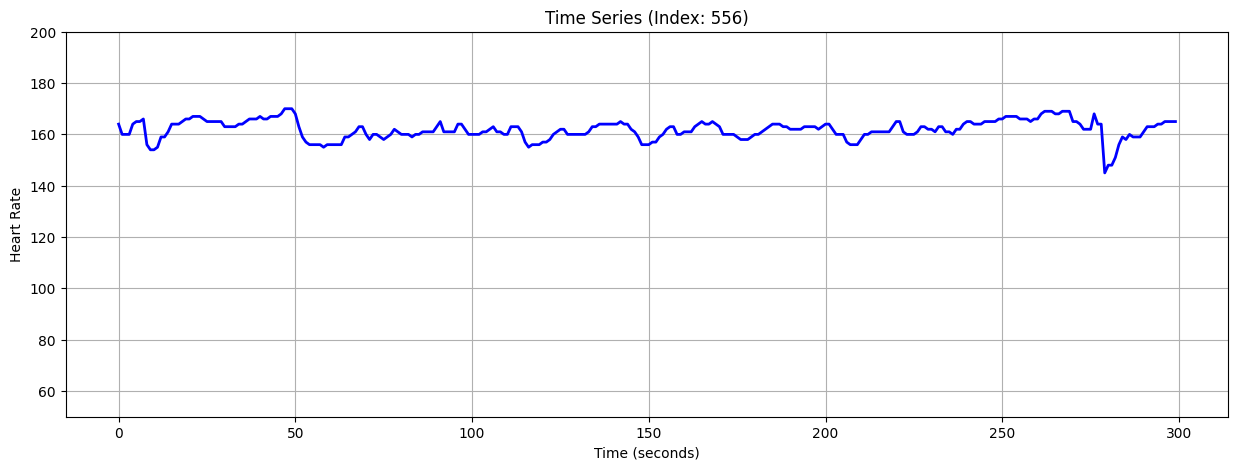

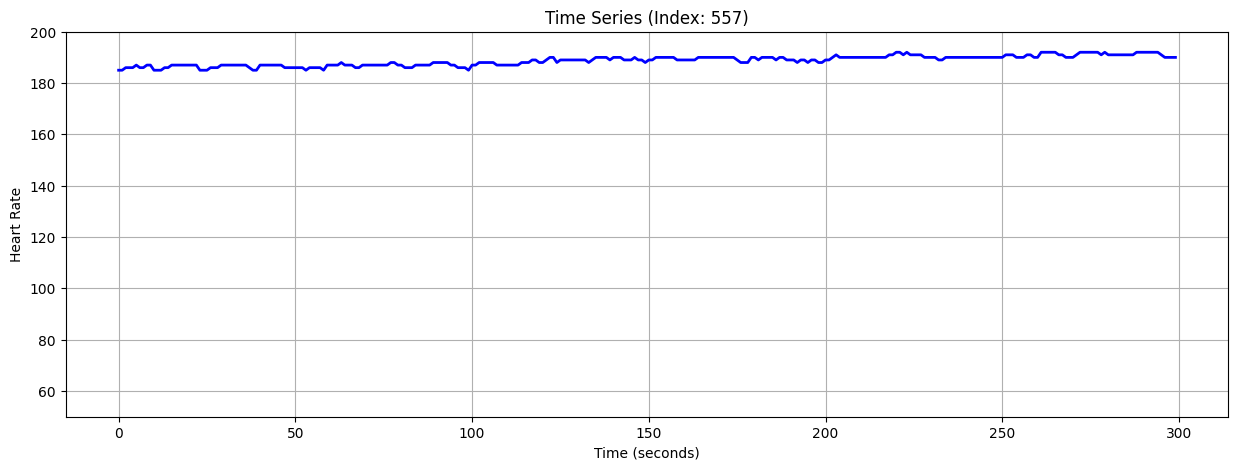

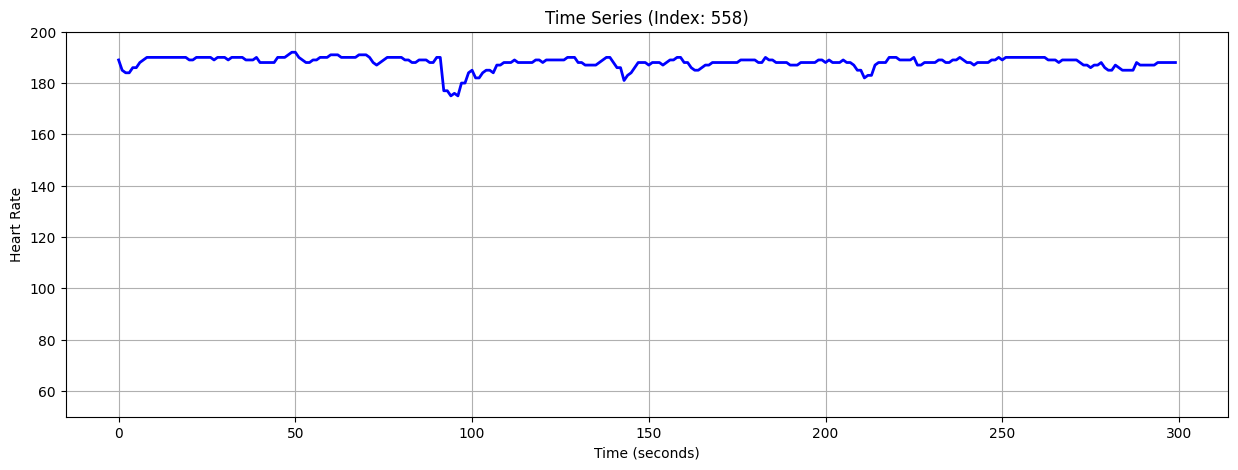

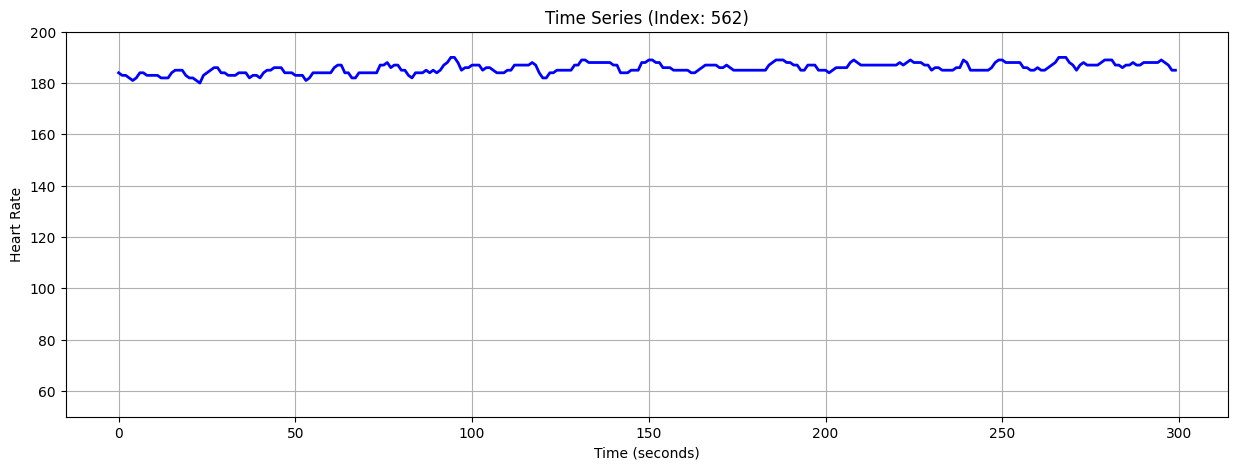

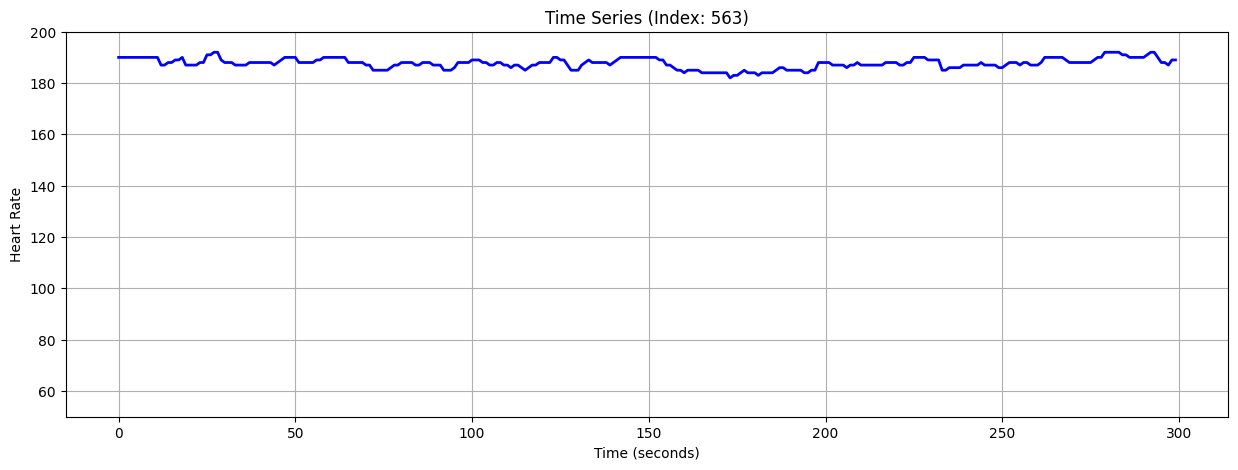

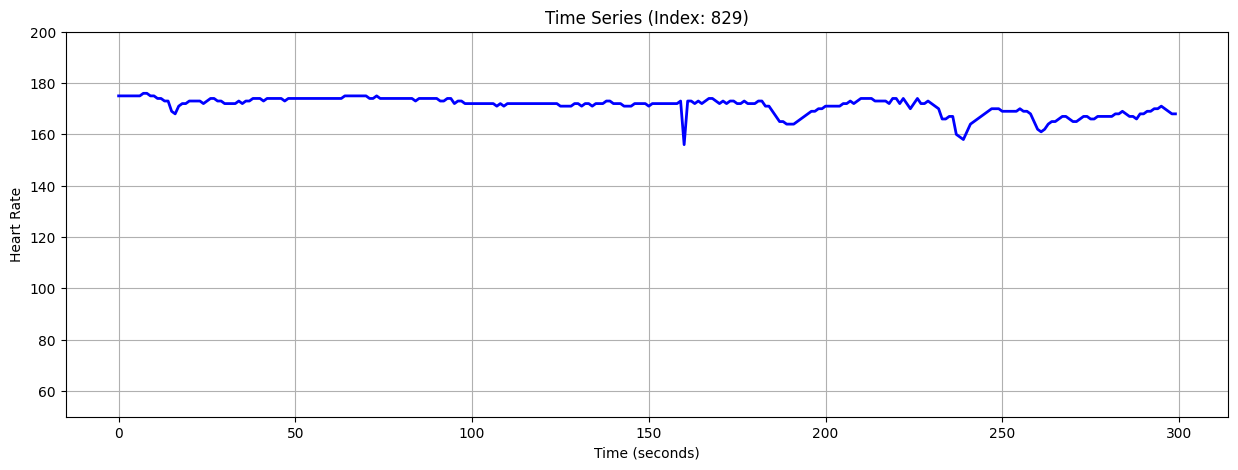

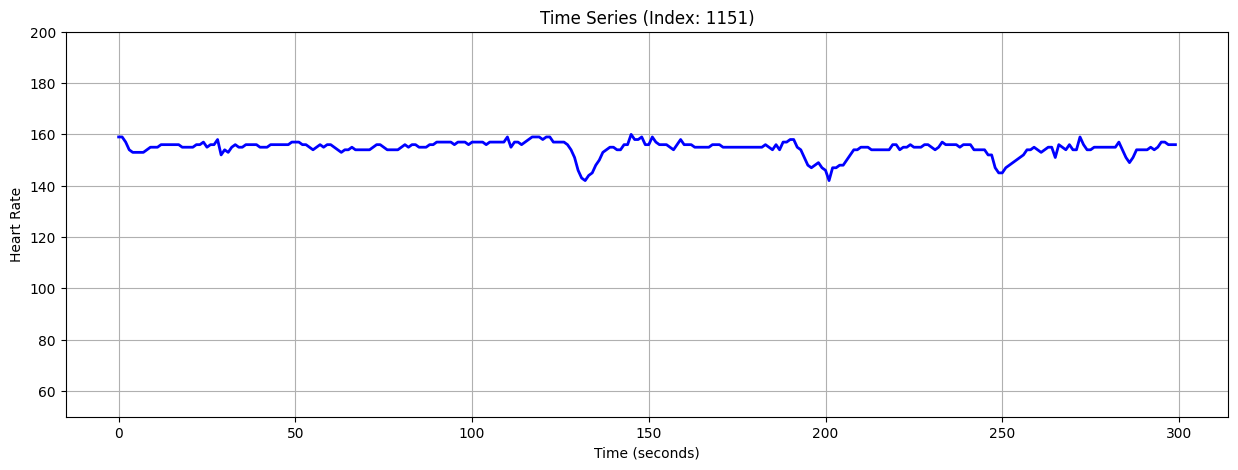

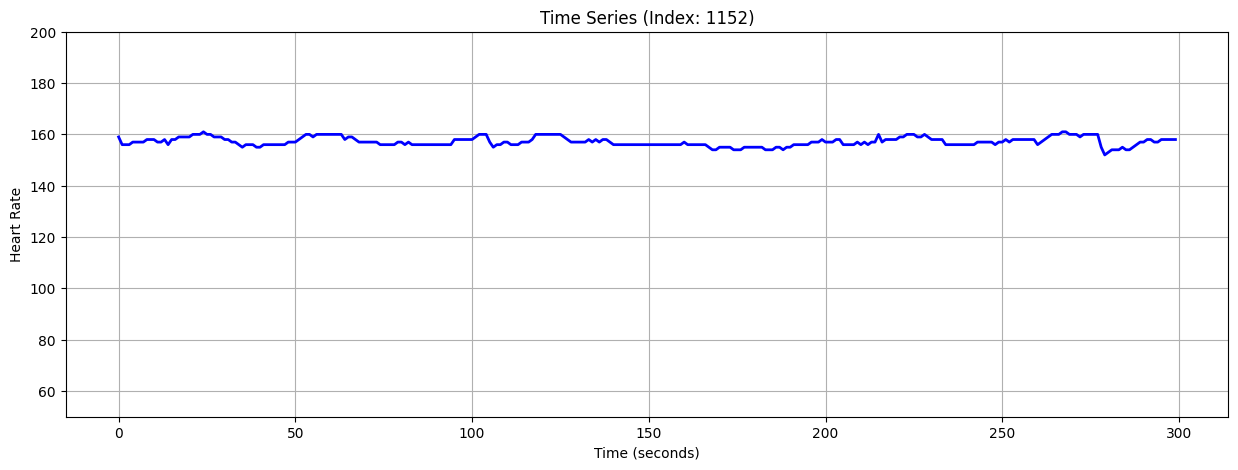

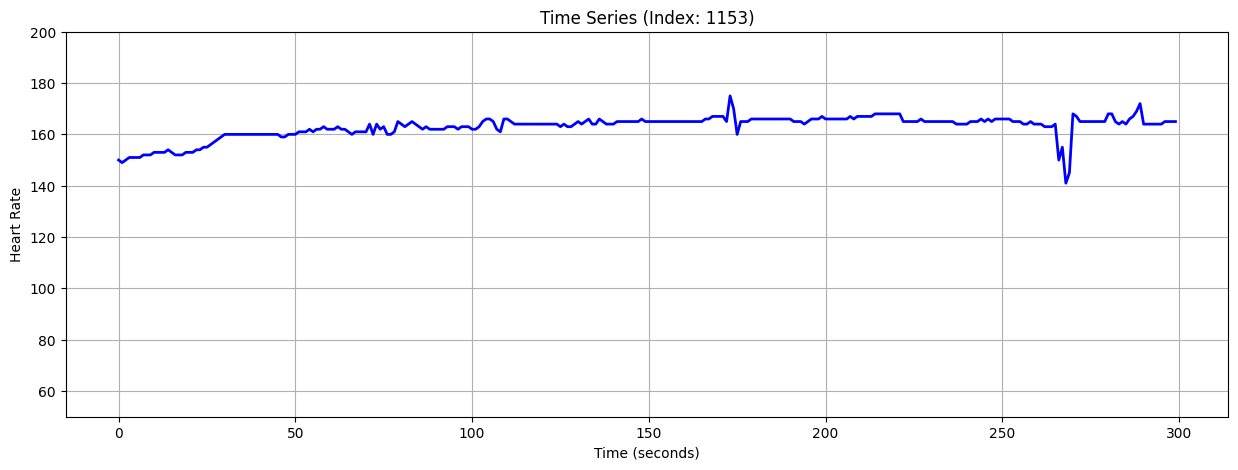

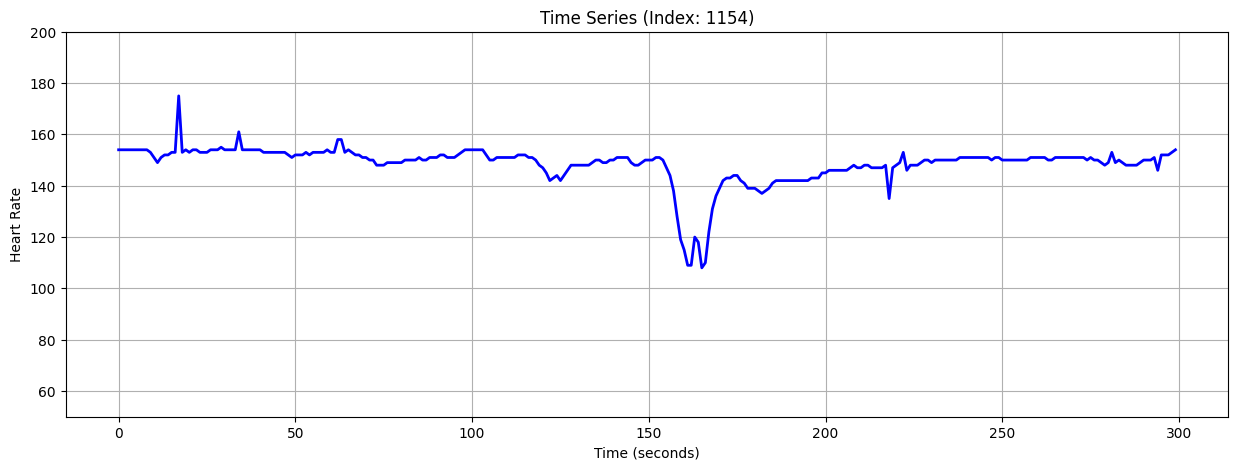

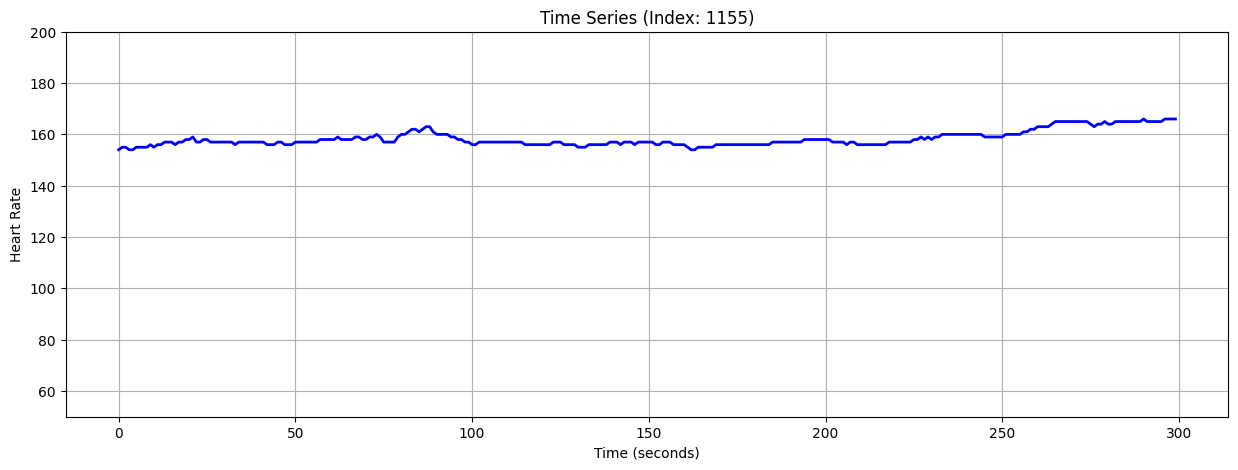

In [15]:

# description_succ_inc
# description_succ_unc
# description_histogram
# description_ts_event
# ts_description
print(df_train['description_succ_unc'].value_counts())
c = 0


for i in df_train[df_train['description_succ_unc'] == "High amount of flat lines."].index:
    plot_ts(df_train, i)
    c += 1
    if c > 10:
        break

# for i in df_train[df_train['description_succ_inc'] == "High amount of consecutive increases."].index:
#     plot_ts(df_train, i)
#     c += 1
#     if c > 10:
#         break

# for i in df_train[df_train['description_succ_inc'] == "Low amount of consecutive increases."].index:
#     plot_ts(df_train, i)
#     c += 1
#     if c > 10:
#         break


# for i in df_train[df_train['description_histogram'] == "Moderate variability."].index:
#     plot_ts(df_train, i)
#     c += 1
#     if c > 10:
#         break


In [6]:
# # for testing purposes way 1
# %load_ext autoreload
# %autoreload 1
# %aimport train

# # way 2 if way 1 not working
# %load_ext autoreload
# %autoreload 2
# import importlib
# import train
# importlib.reload(train)

### Customize VITAL Model

In [7]:
# customize model
if overwrite or not os.path.exists(model_path):    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path, map_location=torch.device(device))
    model = config_dict['model_init']
    print(nn_summary(model))
    model.device = device

    

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─LocalNorm: 2-1                                                  --
│    └─Sequential: 2-2                                                 --
│    │    └─MultiLSTMEncoder: 3-1                                      11,111,424
│    │    └─LayerNorm: 3-2                                             512
│    │    └─Linear: 3-3                                                131,584
│    │    └─LeakyReLU: 3-4                                             --
│    │    └─LayerNorm: 3-5                                             1,024
│    │    └─Linear: 3-6                                                262,656
│    │    └─LeakyReLU: 3-7                                             --
│    │    └─LayerNorm: 3-8                                             1,024
│    └─Li

### Train clip for ts and txt encoders first

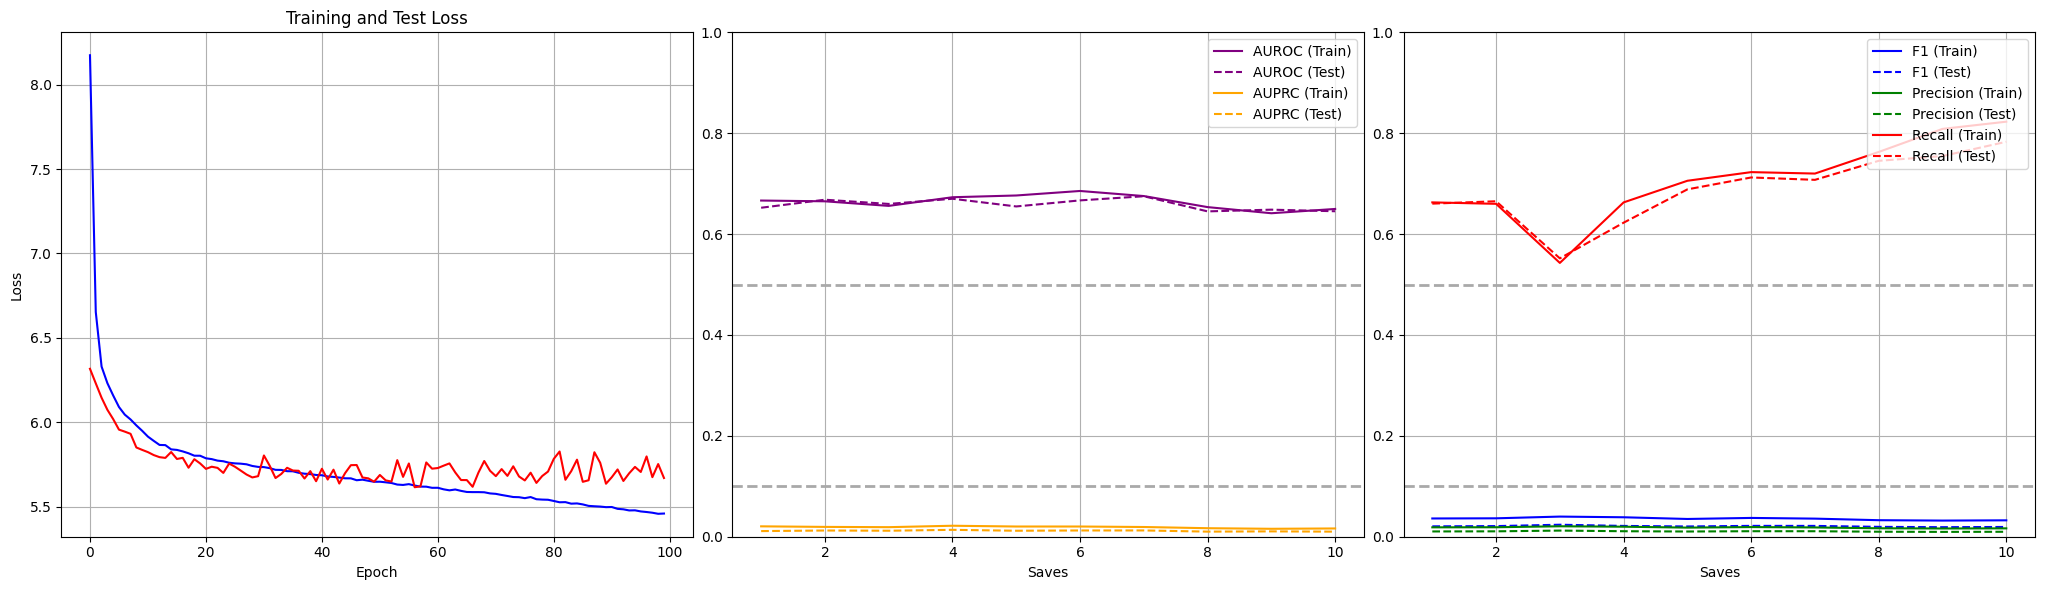

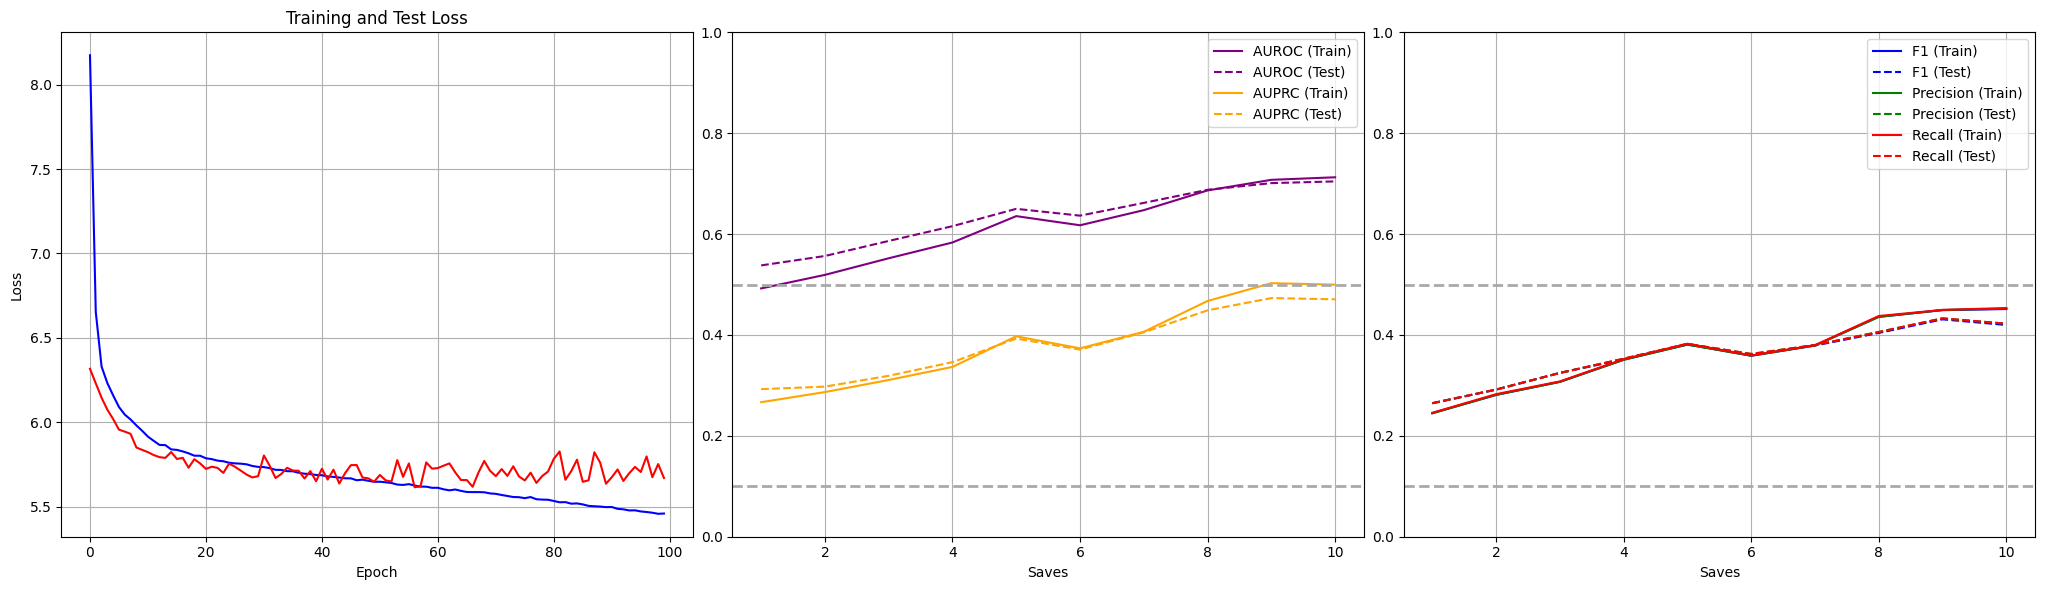

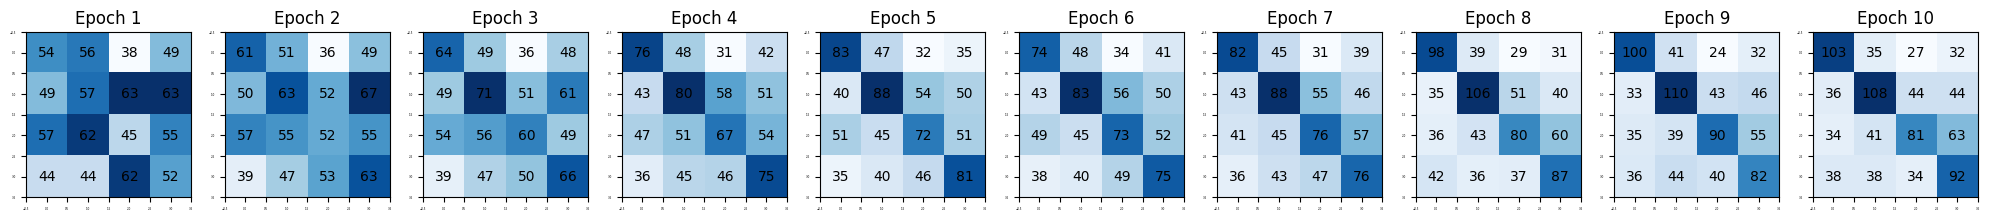

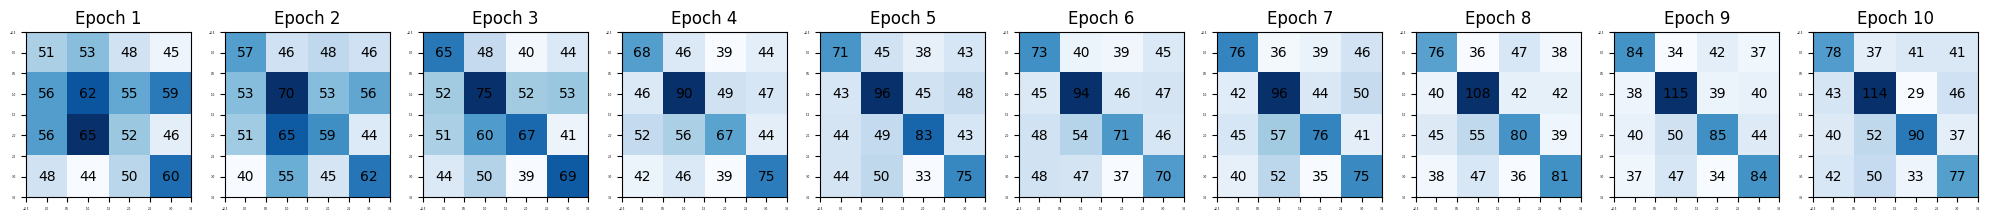

In [8]:
if overwrite or not os.path.exists(model_clip_path):

    # ------------------------- ready training for clip -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=100,      
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more

    
    for i in range(config_dict['num_saves']):  # n_evals
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        train_type='clip',
                                                        alpha = 1/1000)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_clip_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')
    
else:
    model.load_state_dict(torch.load(model_clip_path, map_location=torch.device(device)))
    model.eval()
    eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
    eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)

### Continue train vae decoder

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


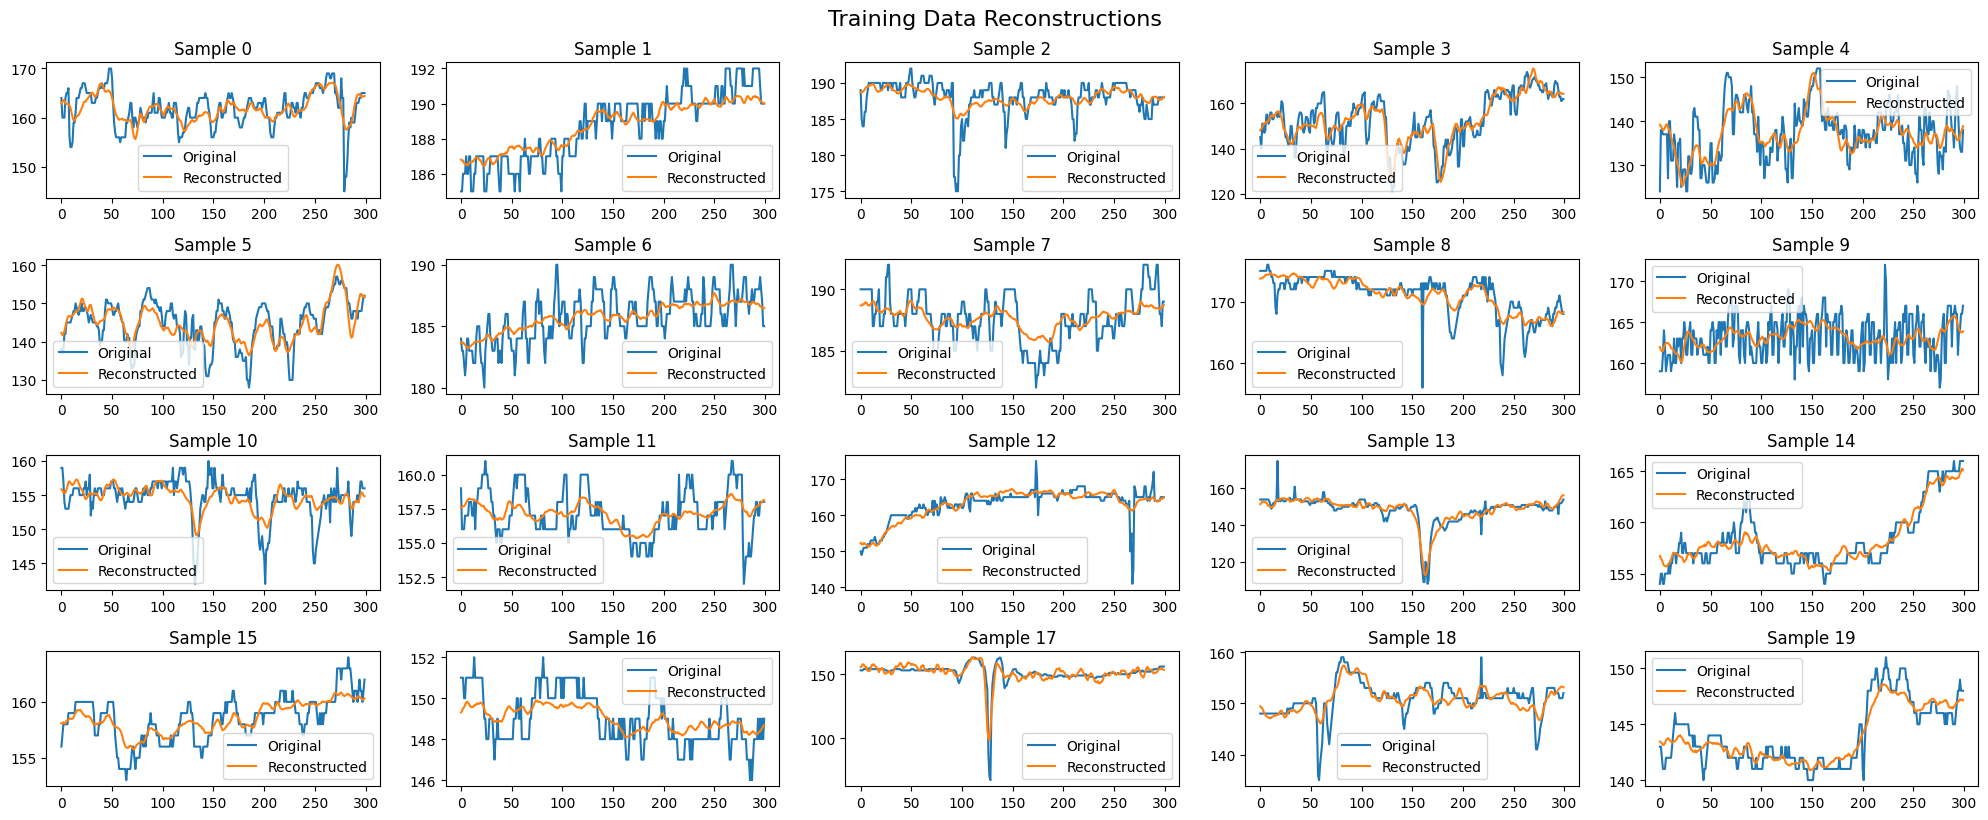

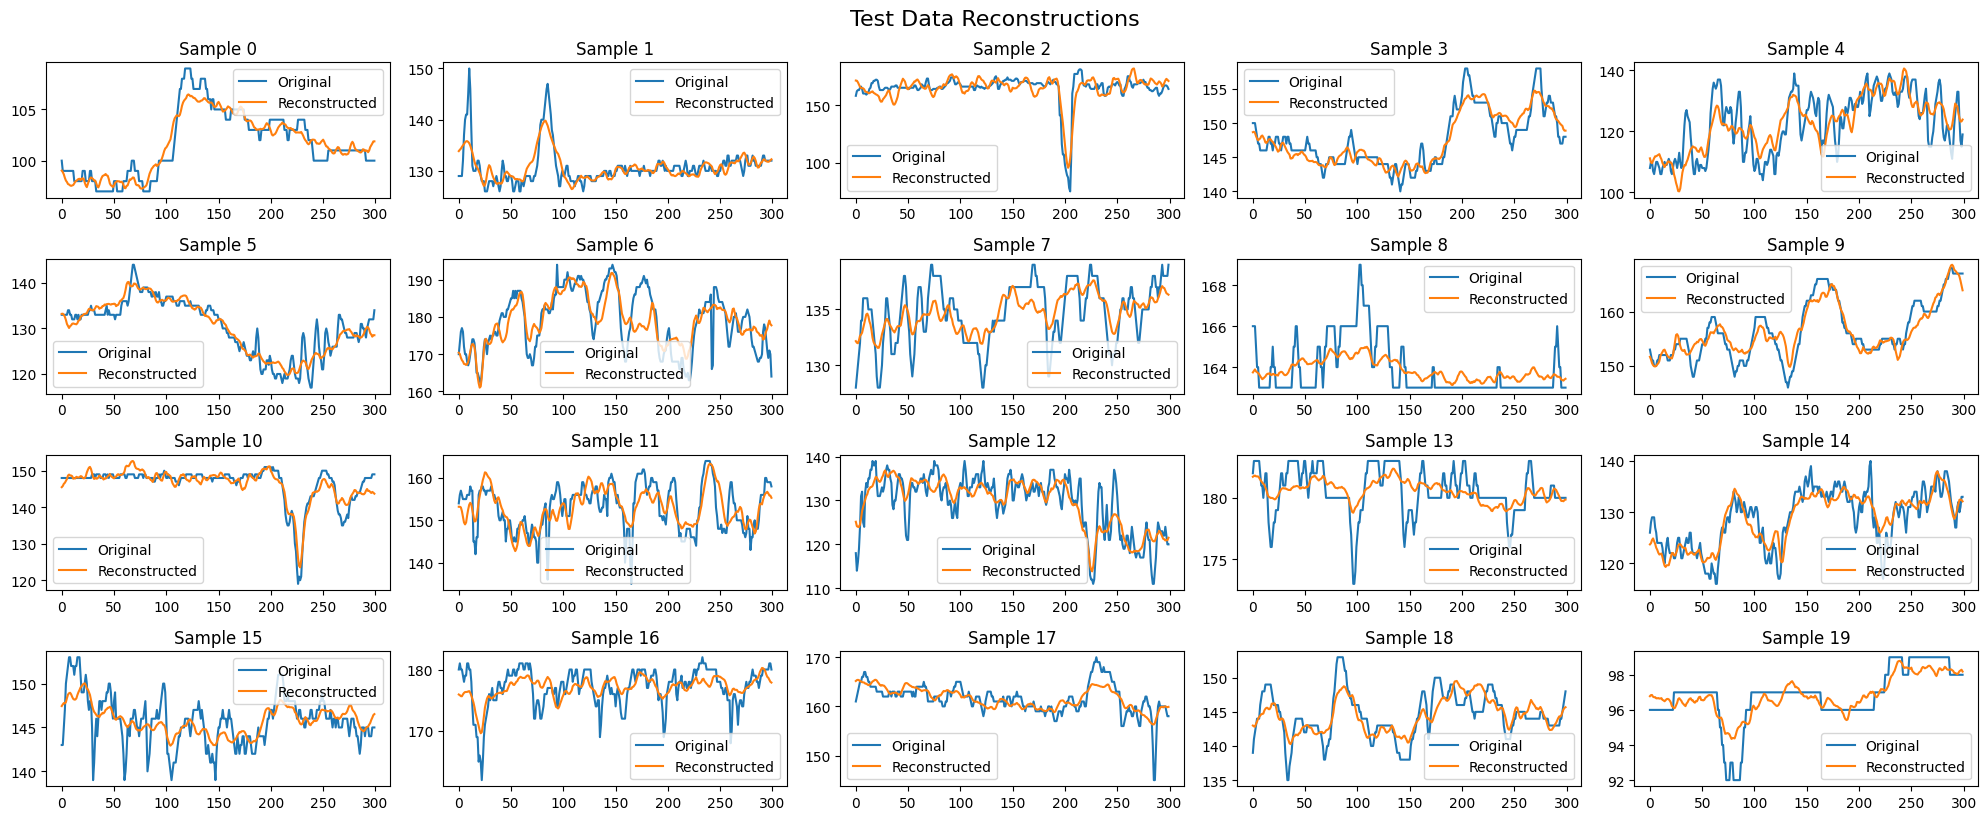

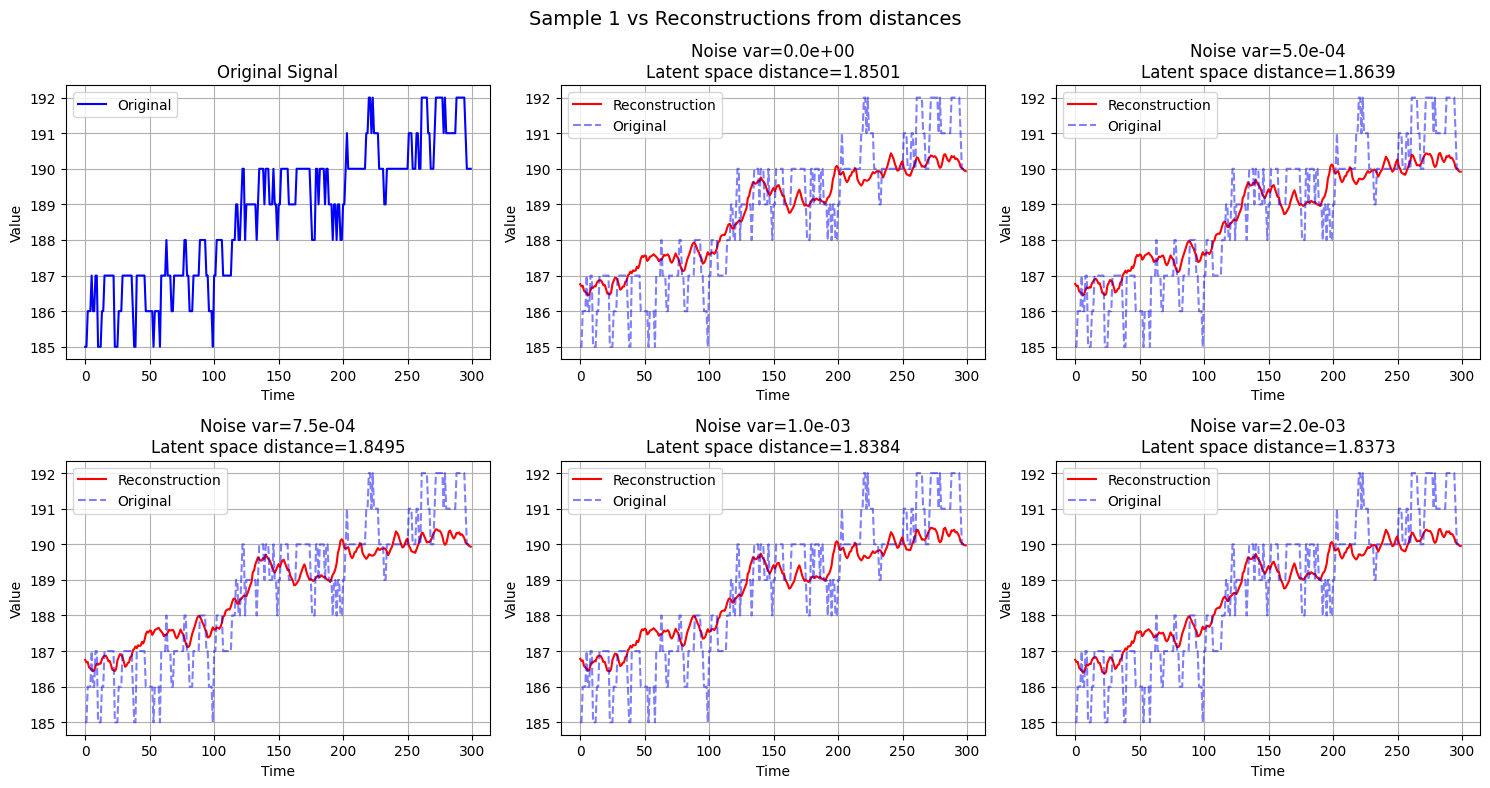

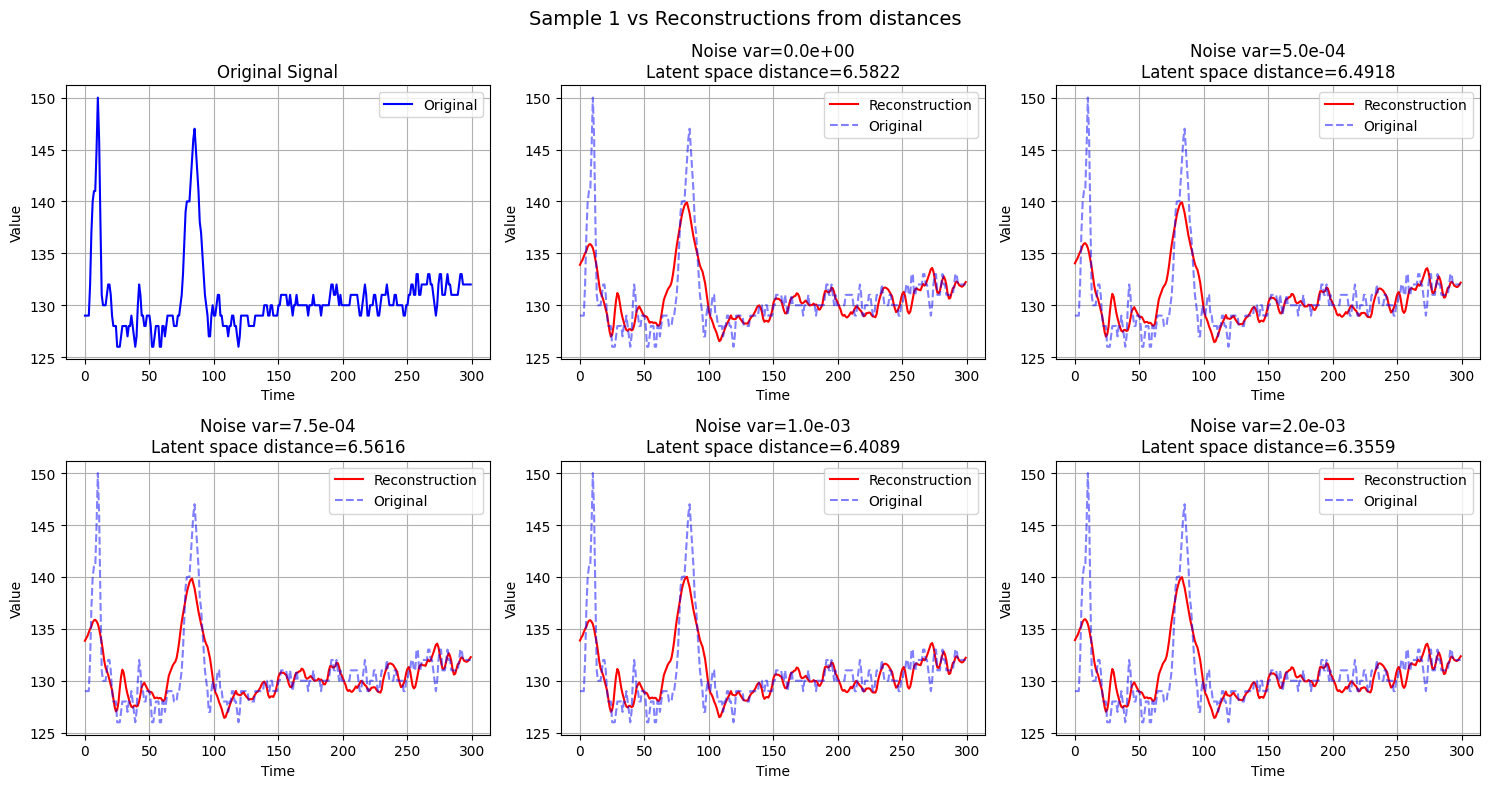

In [9]:
overwrite = False
if overwrite or not os.path.exists(model_path):
    # load model and eval from checkpoint of clip
    model.load_state_dict(torch.load(model_clip_path))
    eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth')
    eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth')
    train_losses = eval_dict_ts2txt['train_losses']
    test_losses = eval_dict_ts2txt['test_losses']
    train_eval_metrics_ts2txt_list = eval_dict_ts2txt['train_evals']
    test_eval_metrics_ts2txt_list = eval_dict_ts2txt['test_evals']
    train_eval_metrics_txt2ts_list = eval_dict_txt2ts['train_evals']
    test_eval_metrics_txt2ts_list = eval_dict_txt2ts['test_evals']
    
    # ------------------------- ready training for vae decoder -------------------------
    # 1. Freeze encoders
    for param in model.ts_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False
    # 2. Unfreeze logvar_layer in ts_encoder to trainable
    for param in model.ts_encoder.logvar_layer.parameters():
        param.requires_grad = True
    # 3. Unfreeze decoder
    for param in model.ts_decoder.parameters():
        param.requires_grad = True
    # Verify parameters
    print("Checking trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}")
    
    # Create optimizer with only trainable parameters
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=100,       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-3,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more


    
    for i in range(config_dict['num_saves']*5):  # n_evals
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs']*10, 
                                                        train_type='joint',
                                                        alpha = 1/1000)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_path)
        # torch.save(eval_dict_ts2txt, output_dir+'/evals_ts2txt.pth')
        # torch.save(eval_dict_txt2ts, output_dir+'/evals_txt2ts.pth')
    
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    # eval vae
    plot_reconstructions(model, 
                        df=df_train, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Training Data Reconstructions")

    plot_reconstructions(model, 
                        df=df_test, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Test Data Reconstructions")

    plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'])
    plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'])
    

### Inference

In [10]:
i = 5
distance_ratios = [10, 50, 100, 200]
threshold = 0
keep = 2
poptop = True
df_infer = df_test.copy()
df = df_infer.iloc[[i]].copy()
print(df['ts_description'].to_list()[0])

Moderate variability. Low amount of consecutive increases. High amount of flat lines.    


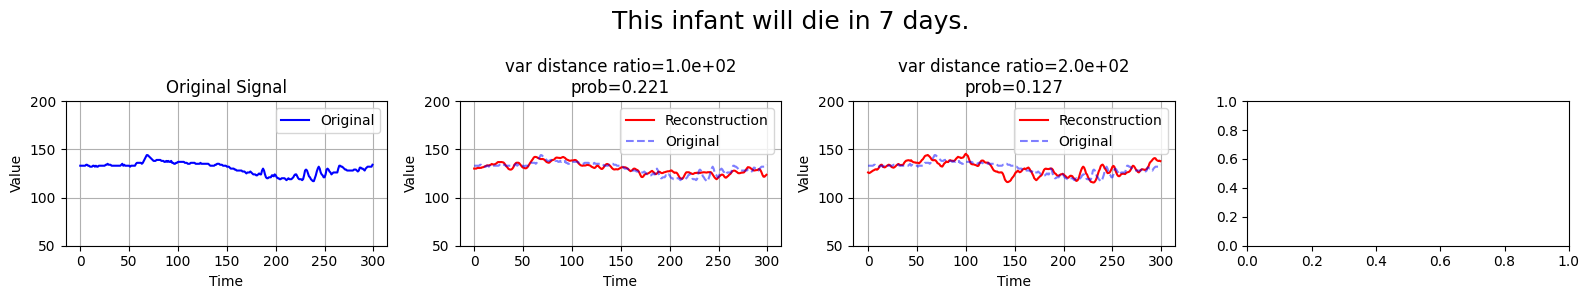

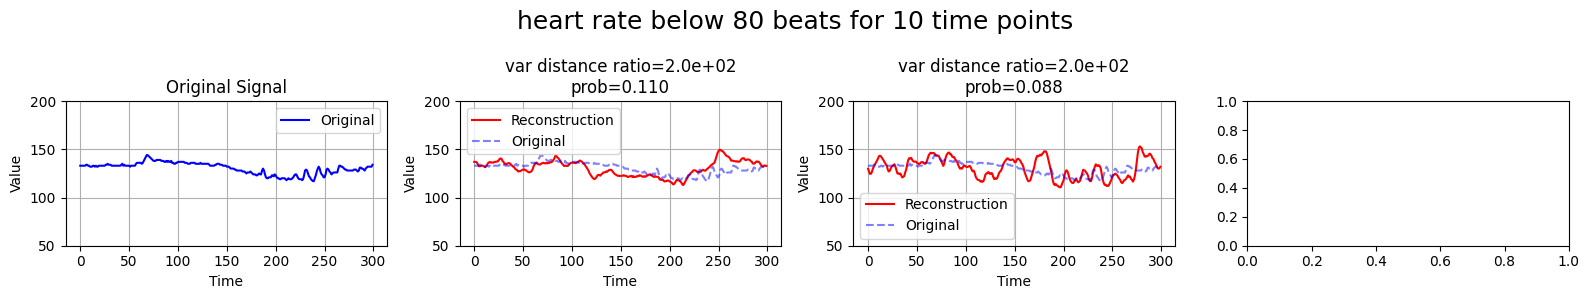

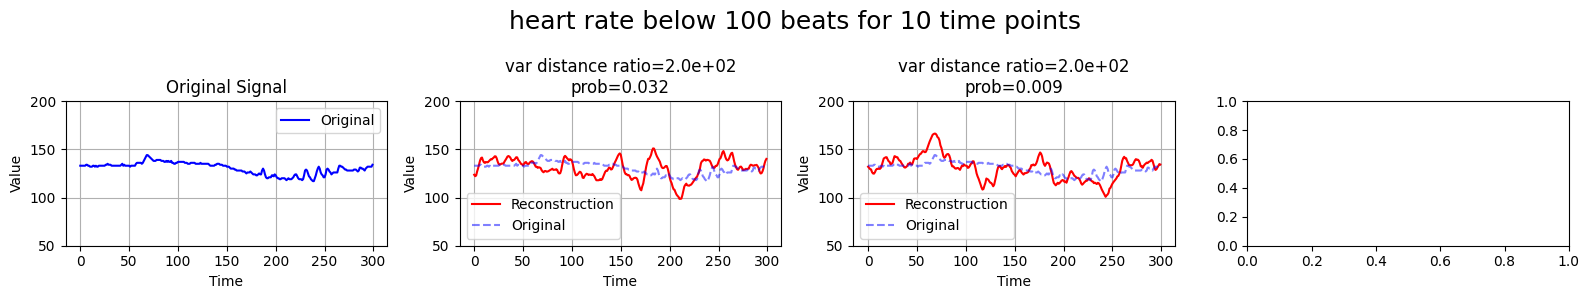

In [11]:
df = df_infer.iloc[[i]].copy()
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['cl_event'].tolist()[0])

df = df_infer.iloc[[i]].copy()
df['text1'] = "heart rate below 80 beats for 10 time points"

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])

df = df_infer.iloc[[i]].copy()
df['text1'] = "heart rate below 100 beats for 10 time points"

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])


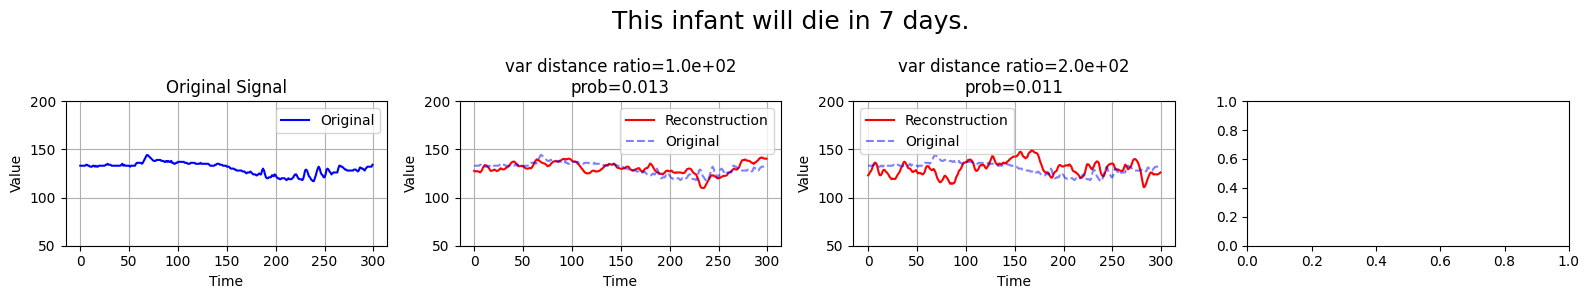

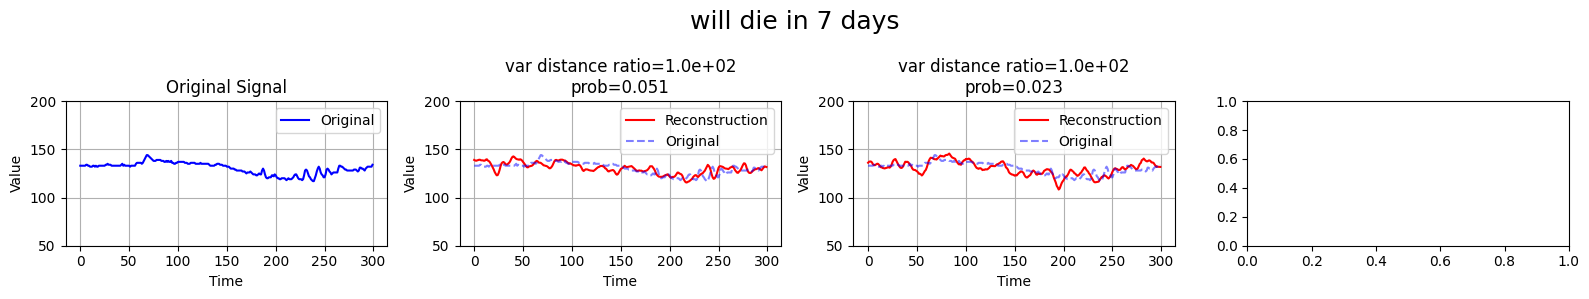

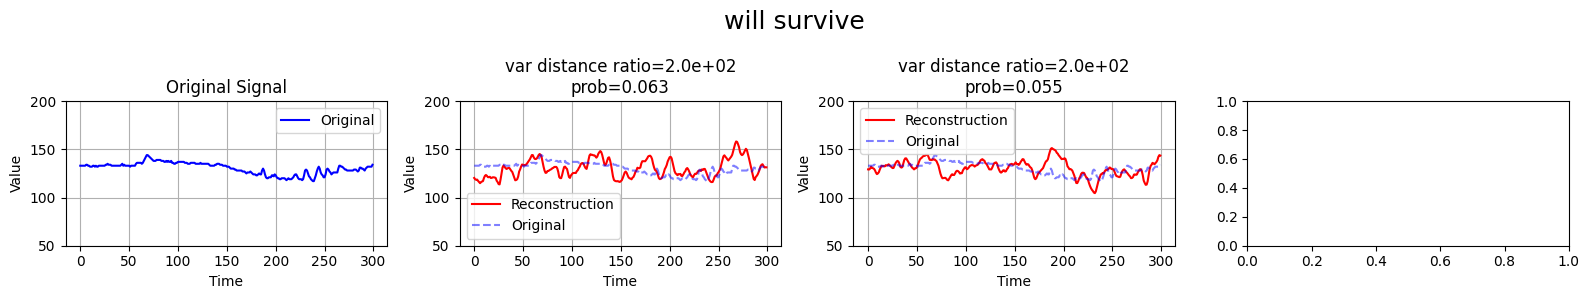

In [12]:
df = df_infer.iloc[[i]].copy()
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['cl_event'].tolist()[0])

df['text1'] = "will die in 7 days"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['text1', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])
df['text2'] = "will survive"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['text2', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text2'].tolist()[0])

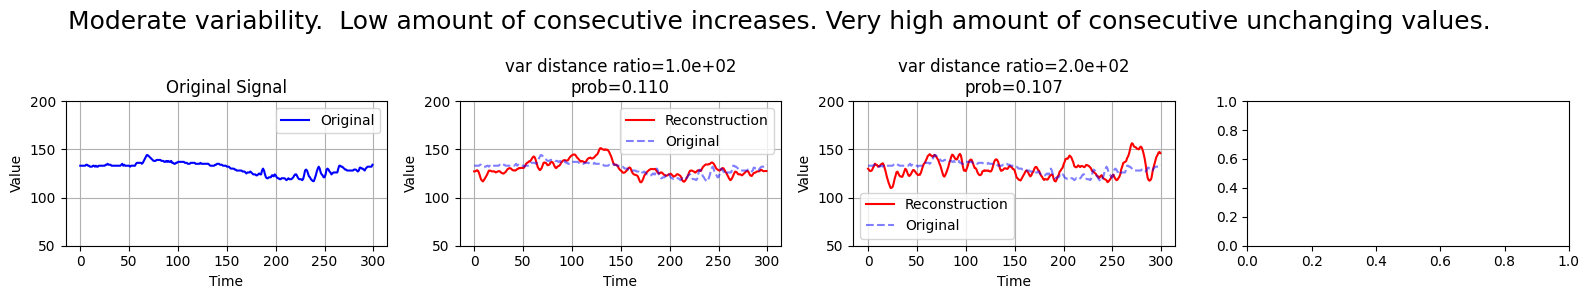

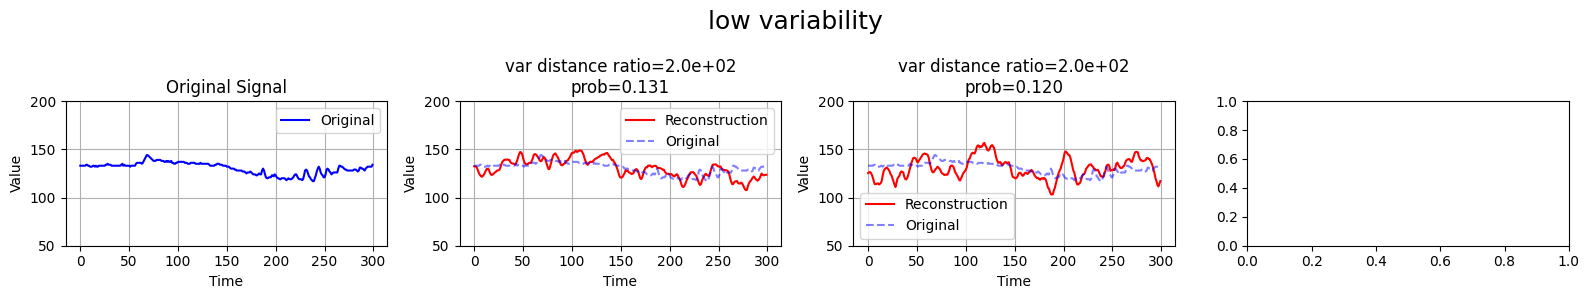

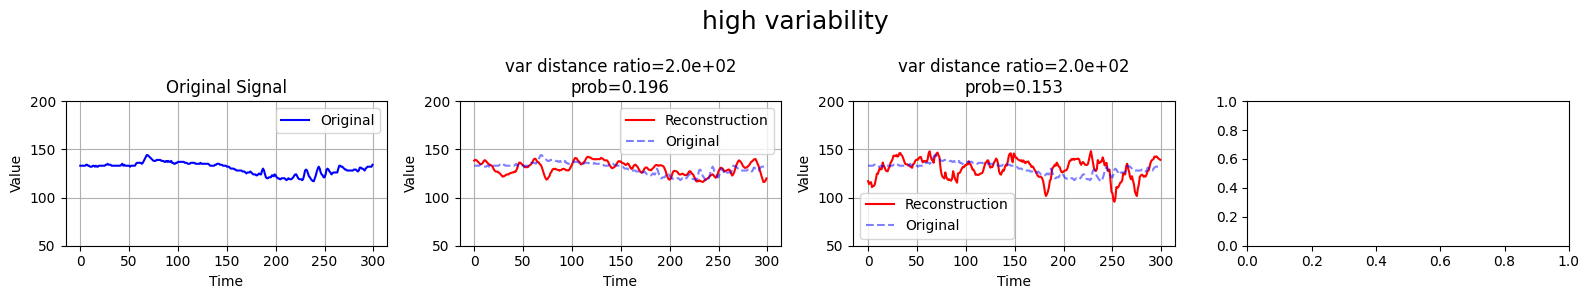

In [397]:
df = df_infer.iloc[[i]].copy()
# df.loc[:,'1':'300'] = np.random.randint(160, 170, size=(df.shape[0], 300))# 300 random integers between 160 and 165
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['ts_description'].tolist()[0])

df['text1'] = "low variability"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])
df['text2'] = "high variability"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text2', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text2'].tolist()[0])


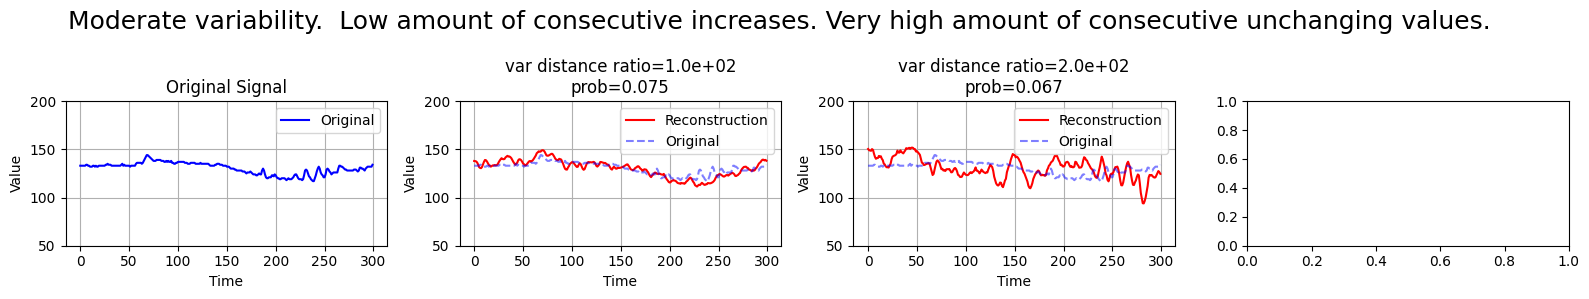

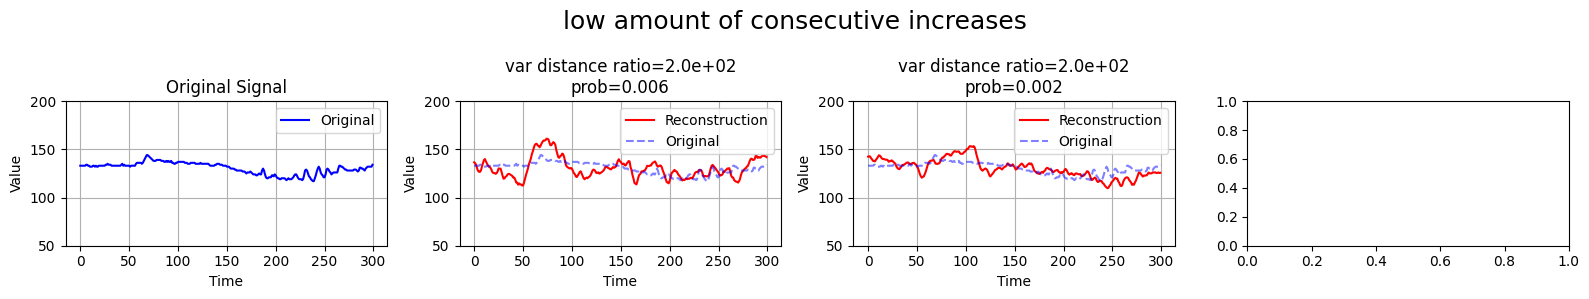

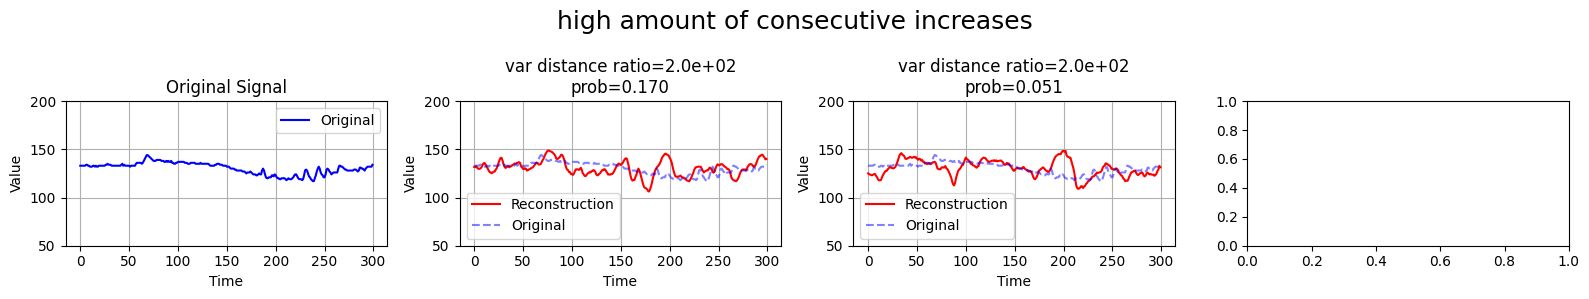

In [398]:
df = df_infer.iloc[[i]].copy()
# df.loc[:,'1':'300'] = np.random.randint(160, 170, size=(df.shape[0], 300))# 300 random integers between 160 and 165
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['ts_description'].tolist()[0])

df['text1'] = "low amount of consecutive increases"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])

df['text2'] = "high amount of consecutive increases"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text2', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text2'].tolist()[0])
